In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [2]:
# read data
DATA_FOLDER_PATH = os.getcwd() + '/../data/KS VERI/'
FILE_NAME = 'KS10_FINAL_DATA.csv'
PATH = DATA_FOLDER_PATH + FILE_NAME
FINAL_DF = pd.read_csv(PATH, header=0)
FINAL_DF['Timestamp'] = pd.to_datetime(FINAL_DF['Timestamp'])

In [3]:
## PUE detect outliers
outliers = FINAL_DF[(FINAL_DF['PUE'] > 2.5) | (FINAL_DF['PUE'] < 1)]

## REPLACE OUTLIERS WITH THE MEAN OF THE ADJACENT VALUES
for i in outliers.index:
    if i == 0:
        FINAL_DF.loc[i, 'PUE'] = FINAL_DF.loc[i + 1, 'PUE']
    elif i == len(FINAL_DF) - 1:
        FINAL_DF.loc[i, 'PUE'] = FINAL_DF.loc[i - 1, 'PUE']
    else:
        FINAL_DF.loc[i, 'PUE'] = (FINAL_DF.loc[i - 1, 'PUE'] + FINAL_DF.loc[i + 1, 'PUE']) / 2


In [4]:
DAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
HOURS = ['hour_' + str(hour) for hour in range(24)]
MONTHS = ['month_' + str(month) for month in range(4, 11)]
column_names = ['Timestamp', 'PUE',
                    
                    'I_KOMP1_HIZ', 
                    #'I_KOMP1_SAAT',
                    #'I_KOMP2_HIZ', 
                    #'I_KOMP2_SAAT',
                    #'I_NEM_SET','I_SIC_SET', 
                    
                    'II_KOMP1_HIZ', 
                    #'II_KOMP1_SAAT',
                    #'II_KOMP2_HIZ',
                    #'II_KOMP2_SAAT',
                    #'II_NEM_SET','II_SIC_SET', 
                    
                    'III_KOMP1_HIZ', 
                    #'III_KOMP1_SAAT',
                    #'III_KOMP2_HIZ', 
                    #'III_KOMP2_SAAT',
                    #'III_NEM_SET','III_SIC_SET', 
                    
                    'IV_KOMP1_HIZ', 
                    #'IV_KOMP1_SAAT',
                    #'IV_KOMP2_HIZ', 
                    #'IV_KOMP2_SAAT',
                    #'IV_NEM_SET',
                    'KS10_UDP_TUKETIM',
                    'CH1_CIKIS_SIC', 'CH1_GIRIS_SIC',
                    'CH2_CIKIS_SIC', 'CH2_GIRIS_SIC', 
                    'CH3_CIKIS_SIC', 'CH3_GIRIS_SIC',
                    
                    'SENSOR_I_TEMP', 'SENSOR_II_TEMP', 
                    'OUTLET_TEMP', 'OUTLET_HUMIDITY'] + DAYS + HOURS + MONTHS

In [5]:
FINAL_DF = FINAL_DF.loc[:, column_names]

In [6]:
# add extra columns

#FINAL_DF["PUE_lag_" + str(1)] = FINAL_DF["PUE"].shift(1)
FINAL_DF["PUE_lag_one_day"] = FINAL_DF["PUE"].shift(24*12)
#FINAL_DF["PUE_lag_one_week"] = FINAL_DF["PUE"].shift(7*24*12)


FINAL_DF.dropna(inplace=True)
FINAL_DF.reset_index(drop=True, inplace=True)

In [7]:
train, test = train_test_split(FINAL_DF, test_size=0.2, random_state=42)

In [8]:
pue = sm.load("PUE_OLS.pkl")
coefs_pue = pue.params
sensor1 = sm.load("SENSOR_I_OLS.pkl")
coefs_sensor1 = sensor1.params
sensor2 = sm.load("SENSOR_II_OLS.pkl")
coefs_sensor2 = sensor2.params

In [9]:
index_cols = dict(zip(range(4), ['I_KOMP1_HIZ', 'II_KOMP1_HIZ', 'III_KOMP1_HIZ', 'IV_KOMP1_HIZ']))

In [30]:
## write optimization model with gurobi
# create a new model
index = []
real_pue = []
optimized_pue = []
real_speeds = [[],[],[],[]]
optimized_speeds = [[],[],[],[]]
for i in range(test.shape[0]):
    try:
        test_data = test.iloc[i]    
        M = gp.Model("ks10")
        coef = 100
        v = M.addVars(range(4), lb=0, ub=100, vtype=GRB.CONTINUOUS, name="v")
        #abs_temp = M.addVars(range(4), lb=0, ub=100, vtype=GRB.CONTINUOUS, name="abs_temp")
        M.setObjective(coefs_pue.I_KOMP1_HIZ * v[0] + 
                        coefs_pue.II_KOMP1_HIZ * v[1] + 
                        coefs_pue.III_KOMP1_HIZ * v[2] + 
                        coefs_pue.IV_KOMP1_HIZ * v[3] +
                        sum([coefs_pue[col] * test_data[col] for col in train.columns[6:]])
                        #coef * sum([abs_temp[i] for i in range(4)])
                    , GRB.MINIMIZE)

        c1 = M.addConstr(
            coefs_sensor1['I_KOMP1_HIZ'] * v[0] + coefs_sensor1['II_KOMP1_HIZ'] * v[1] + coefs_sensor1['III_KOMP1_HIZ'] * v[2] + coefs_sensor1['IV_KOMP1_HIZ'] * v[3]
            + sum([coefs_sensor1[col] * test_data[col] for col in coefs_sensor1.index if "KOMP" not in col and col != "Intercept"]) + coefs_sensor1.Intercept <= np.log(24)
        )

        c2 = M.addConstr(
            coefs_sensor1['I_KOMP1_HIZ'] * v[0] + coefs_sensor1['II_KOMP1_HIZ'] * v[1] + coefs_sensor1['III_KOMP1_HIZ'] * v[2] + coefs_sensor1['IV_KOMP1_HIZ'] * v[3]
            + sum([coefs_sensor1[col] * test_data[col] for col in coefs_sensor1.index if "KOMP" not in col and col != "Intercept"]) + coefs_sensor1.Intercept >= np.log(14)
        )

        c3 = M.addConstr(
            coefs_sensor2['I_KOMP1_HIZ'] * v[0] + coefs_sensor2['II_KOMP1_HIZ'] * v[1] + coefs_sensor2['III_KOMP1_HIZ'] * v[2] + coefs_sensor2['IV_KOMP1_HIZ'] * v[3]
            + sum([coefs_sensor2[col] * test_data[col] for col in coefs_sensor2.index if "KOMP" not in col and col != "Intercept"]) + coefs_sensor1.Intercept <= np.log(24)
        )

        c4 = M.addConstr(
            coefs_sensor2['I_KOMP1_HIZ'] * v[0] + coefs_sensor2['II_KOMP1_HIZ'] * v[1] + coefs_sensor2['III_KOMP1_HIZ'] * v[2] + coefs_sensor2['IV_KOMP1_HIZ'] * v[3]
            + sum([coefs_sensor2[col] * test_data[col] for col in coefs_sensor2.index if "KOMP" not in col and col != "Intercept"]) + coefs_sensor1.Intercept >= np.log(14)
        )

        c5 = M.addConstrs(v[i] >= 0.5*FINAL_DF.loc[int(test_data.name)-1][index_cols[i]] for i in range(4))
        c6 = M.addConstrs(v[i] <= 1.5*FINAL_DF.loc[int(test_data.name)-1][index_cols[i]] for i in range(4))

        #abs_tempc1 = M.addConstrs(abs_temp[i] >= v[i] - FINAL_DF.loc[int(test_data.name)-1][index_cols[i]] for i in range(4))
        #abs_tempc2 = M.addConstrs(abs_temp[i] >= FINAL_DF.loc[int(test_data.name)-1][index_cols[i]] - v[i] for i in range(4))
        ## solve gurobi model
        M.optimize()

        ## print results
        #for v_ in M.getVars():
        #    print('%s %g' % (v_.varName, v_.x))

        #print(f'Obj: {np.exp(M.objVal)+1}')
        #for i in range(4):
        #    print(f"Difference: {v[i].x - FINAL_DF.loc[int(test_data.name)-1][index_cols[i]]}")
        #print(f"Penalty: {coef * sum([abs_temp[i].x for i in range(4)])}")
        #print("****************************"*3)
        #print(f"Real PUE: {test_data.PUE}")
        optimized_pue.append(np.exp(M.objVal)+1)
        #print(f"Optimized PUE: {np.exp(M.objVal)+1}")
        for i in range(4):
            to_append = 0
            if i == 0:
                to_append = test_data["I_KOMP1_HIZ"]
            elif i == 1:
                to_append = test_data["II_KOMP1_HIZ"]
            elif i == 2:
                to_append = test_data["III_KOMP1_HIZ"]
            else:
                to_append = test_data["IV_KOMP1_HIZ"]
            real_speeds[i].append(to_append)
            optimized_speeds[i].append(v[i].x)
        index.append(test_data.name)
        real_pue.append(test_data.PUE)
    except:
        continue

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf9fcce58
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7355282e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.735528208e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x55ffa8b8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7269931e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.726993076e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbae9d48d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7637081e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.763708082e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7783988e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.778398789e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6b7b87fb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6bd80095
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7886860e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.788685975e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe1a10246
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6493774e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.649377366e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x93b6f9f8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7838073e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.783807315e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 6e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6264730e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.626472989e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x19f12df7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe36559a1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7364355e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.736435540e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe2d001ae
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6963255e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.696325503e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x63785830
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8954323e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.895432318e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7018945e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.701894528e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9c03a9f9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x29f17f58
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7174440e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.717443967e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5ac4d658
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9033981e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.903398118e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc8b38c39
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7341710e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.734170974e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6187320e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.618732027e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3b929b29
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x973aa752
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7512383e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.751238338e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xde23161d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7903862e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.790386170e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc8743c17
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7449338e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.744933764e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8913943e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.891394278e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0f07b842
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc20bf523
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8173157e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.817315709e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7db15dea
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb409c6a3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7476163e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.747616283e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x31556fe5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7742945e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.774294508e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe0e42e13
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7560442e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.756044160e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6266718e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.626671796e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb07e6b14
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x33972a81
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7498901e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.749890077e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x02179e3a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8462418e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.846241781e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe5c5e60a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8480473e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.848047346e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7337192e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.733719228e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe1fd5a8d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x69b704d0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 6e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9743715e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.974371544e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x75199f49
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7436542e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.743654168e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xcae974d1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6933292e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.693329153e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6116482e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.611648224e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb2523a8c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Model fingerprint: 0xf8c0ad41
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8303336e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.830333564e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x88e93f42
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.801753315e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc9ab85ed
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8188160e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.818816005e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x41c8c6e3
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9444308e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.944430842e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe4646f20
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7061954e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.706195423e+00
Gurobi Optimiz

Model fingerprint: 0x7e9cb0d0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7999793e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.799979278e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6e423db3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.772581397e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbcc3dca1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8362540e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.836254041e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd91f3cf6
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7951221e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.795122135e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc3ea80a4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8502002e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.850200237e+00
Gurobi Optimiz

Model fingerprint: 0x670754b8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7641270e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.764127049e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xdd1e883f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8007588e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.800758796e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe7758a16
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7835808e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.783580815e+00
Gurobi Optimizer version 9.5.2 buil

Model fingerprint: 0x679cb86b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8694855e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.869485492e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x66bbc491
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.888620414e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x61b59556
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8101751e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.810175066e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x347254da
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8155823e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.815582339e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1f57c6cd
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9364492e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.936449195e+00
Gurobi Optimiz

Model fingerprint: 0x1caefbf3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9215430e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.921543036e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf325018c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.811422201e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8512c50e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8644796e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.864479631e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x950e8f27
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7692941e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.769294080e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x4e952cf7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8526504e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.852650413e+00
Gurobi Optimiz

Model fingerprint: 0x1cdf12e7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7265249e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.726524886e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe473b62a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.698595583e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xecf523ee
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7460904e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.746090411e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7d85ac9e
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7749021e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.774902133e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x285d18df
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7568602e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.756860202e+00
Gurobi Optimiz

Model fingerprint: 0x8865e03b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7384799e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.738479892e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8a9cee7d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [9e-02, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.854425044e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3c3374f1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8617889e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.861788884e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x45addf5a
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7428744e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.742874376e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc8a25fb0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6954560e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.695455991e+00
Gurobi Optimiz

Model fingerprint: 0xc1b0ec23
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7285661e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.728566133e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc0481433
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.824852647e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa29e7aab
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8282773e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.828277345e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6d31de4e
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7283701e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.728370103e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x500427c7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7103798e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.710379757e+00
Gurobi Optimiz

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbe7a916c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [7e-02, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6956324e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.695632355e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x70f0f475
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7736384e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.773638381e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6be039fc
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 6e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8326268e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.832626773e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7662861e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.766286098e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1f7903b3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8b8e357d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8267789e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.826778883e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc3a36728
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7453919e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.745391895e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x993a2b1b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8030578e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.803057817e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7400118e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.740011821e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xcabb2223
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x404e9261
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7235775e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.723577505e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3a070421
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6206961e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.620696056e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5eee2811
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7966239e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.796623880e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6995252e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.699525179e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x938f5f3d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc9c6f655
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-02, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9993249e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.999324896e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x97396c9d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7714057e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.771405732e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe1703bcb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7571632e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.757163158e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7613028e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.761302751e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3037fcf9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd570798b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7265458e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.726545849e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xdeceb575
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7705480e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.770548027e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2b90c627
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7190760e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.719076041e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7285550e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.728554979e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x54b7fd30
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x47c7b2d9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7865708e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.786570811e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbc8c5253
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model fingerprint: 0xfc0e3f4f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9467880e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.946788024e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x842045f1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.764629026e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3eaea9c6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6785505e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.678550461e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xeebcdce7
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4731295e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.473129471e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xcc2c27b5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8982400e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.898240041e+00
Gurobi Optimiz

Model fingerprint: 0x7d98df58
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6596977e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.659697710e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x67b81bba
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.757660672e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfea955e5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7173213e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.717321254e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xcb982f7e
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7024717e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.702471697e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6f809301
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7556211e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.755621069e+00
Gurobi Optimiz

Model fingerprint: 0xcf6a4abd
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7871821e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.787182085e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7cbbe3d3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.763513069e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x754c22be
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8014727e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.801472668e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x137d9371
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7407446e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.740744598e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe73205fb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7564659e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.756465874e+00
Gurobi Optimiz

Model fingerprint: 0xe4f9ec0f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8491199e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.849119866e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x529b4399
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.864296024e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3f15d8b6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8853362e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.885336229e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0b6f5428
Coefficient statistics:
  Matrix range

Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6450197e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.645019708e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xcb57d2d2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6331954e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.633195449e+00
Gurobi Optimiz

Model fingerprint: 0x4c3e9339
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6994963e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.699496253e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x4d5d9a9f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.812333190e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x383af791
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6946728e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.694672804e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf5b4007b
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9093944e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.909394442e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe096e8a3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7956024e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.795602442e+00
Gurobi Optimiz

Model fingerprint: 0xe9e8ffde
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8619611e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.861961070e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x88ff8736
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x50cca7ed
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6549155e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.654915473e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x64e7c771
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7771023e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.777102342e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf8d3b4ac
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8941019e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.894101913e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7569780e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.756978019e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x390e613c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8750317e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x28d89ab1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7539967e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.753996663e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x43390a5a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7718988e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.771898752e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7cf8c3d3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8931845e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.893184485e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6404365e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.640436453e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xef913ffa
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8564047e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc4407a30
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8573859e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.857385861e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb29fcfdc
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7064799e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.706479905e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x694bc963
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6697045e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.669704480e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7802150e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.780214999e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7428377c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5404196e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x66045cf1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8921626e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.892162619e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9797ce32
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.6993115e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.699311513e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x18692cb7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7973570e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.797356973e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7545392e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.754539168e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3ec28d97
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9080087e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfa33a57b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7378833e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.737883272e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3e4e042f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7670559e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.767055859e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x55a424c3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7428356e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.742835621e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6927293e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.692729337e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb698ae62
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7540115e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8f1cf4cb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7820085e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.782008525e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6fd24b70
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7133526e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.713352573e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa65a2076
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8255307e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.825530660e+00
Gurobi Optimiz

Model fingerprint: 0xa84ab3dd
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7089699e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.708969907e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb3f44dd7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.786940575e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa48d53f0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5785045e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.578504470e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa274a6d5
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8998543e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.899854328e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5251caa2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7484479e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.748447938e+00
Gurobi Optimiz

Model fingerprint: 0x5206b771
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8649728e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.864972795e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xddd3102b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.821211202e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xea42a0f5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8512700e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.851269968e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x4ad36e83
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6814706e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.681470590e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3801b656
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.07s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7180825e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.718082458e+00
Gurobi Optimiz

Model fingerprint: 0x358d7847
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8818972e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.881897226e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb01f6001
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.767651636e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x23983bc3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6962837e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.696283689e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6e09da1a
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8297324e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.829732368e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfbe0c99b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7269860e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.726985995e+00
Gurobi Optimiz

Model fingerprint: 0xcc984099
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7118320e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.711831983e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa8bdd60b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.504179219e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x86d24ebf
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8735224e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.873522415e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xeebde2a0
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6751486e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.675148573e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x84ddd6d7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8179622e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.817962209e+00
Gurobi Optimiz

Model fingerprint: 0xa8c56a01
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7830022e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.783002237e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3a8a4f0a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.860206461e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x73c25c00
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7788221e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.778822066e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7952f85f
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6667577e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.666757703e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf9f88fc2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8617883e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.861788309e+00
Gurobi Optimiz

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.886498816e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0cc4f1b0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8754785e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.875478534e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7099688e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.709968838e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb42d55b3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9143423e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xde551254
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5714567e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.571456745e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x4335fb91
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.632673779e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6901760a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8718505e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.871850484e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7573814e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.757381435e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x81f1bf26
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7099401e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x86e52aa2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8464210e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.846421026e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc45cb71a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.809243069e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x13e28408
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7821748e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.782174804e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5971781e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.597178113e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x07cf4582
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7636259e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xecd7a5cb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7107151e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.710715055e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x95c75e0c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.704231472e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbce69b1b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6693402e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.669340196e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6389828e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.638982821e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xce2aa541
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8894551e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x27bdd3db
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8587913e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.858791266e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5eb1ca08
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.768884467e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9417238f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8931446e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.893144599e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8394382e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.839438164e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0b24d34f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7250808e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x408d8e72
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7681419e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.768141925e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9871c490
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.756737515e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x24932ad0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9007718e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.900771840e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7537824e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.753782352e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x811516aa
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7828579e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 se

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd946f080
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7499529e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.749952864e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x64319570
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.770147230e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6bc00886
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7235511e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.723551128e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9002791e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.900279128e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5ad7262f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8426847e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe9d54e15
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6732838e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.673283846e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xeea93f8e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.739715637e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf238e3e3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8161096e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.816109614e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8631914e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.863191400e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xcfcd0f6b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6902565e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6e245ab8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7650868e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.765086846e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x462aa64e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.793902115e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x63c90089
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8447267e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.844726662e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9078358e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.907835780e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x363741c9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8968790e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x79acc6ec
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6851038e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.685103799e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3afbc7ea
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.874702196e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa69454ce
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5698817e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.569881681e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8973456e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.897345636e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa2686dac
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7681257e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x01d2e522
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7440579e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.744057915e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x28ef27f2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.813375717e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0f73e9ea
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7791011e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.779101067e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8370822e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.837082207e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb5793ae1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7282327e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6988914e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.698891381e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa61846cb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5738412e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.573841214e+00
Gurobi Optimizer version 9.5.2 buil

Model fingerprint: 0x456f746e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7182417e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.718241669e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc1c8c065
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.583714169e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf385de58
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7279044e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.727904375e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2d4596b4
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7281147e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.728114672e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x76d355ca
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8998391e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.899839090e+00
Gurobi Optimiz

Model fingerprint: 0xe1664864
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-02, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9715362e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.971536158e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x385b2ebe
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.749335789e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd755658e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8000219e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.800021922e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xca3c1d0a
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7979200e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.797920027e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x40717dd0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9057010e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.905700974e+00
Gurobi Optimiz

Model fingerprint: 0x3a02ac84
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8176121e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.817612053e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1ea70cdd
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.923394871e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3a9ad38a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8581779e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.858177906e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0619859d
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8034978e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.803497776e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe89bb9b4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9013571e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.901357124e+00
Gurobi Optimiz

Model fingerprint: 0x619c72db
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8660256e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.866025649e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3f7843b2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.728287094e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc5a9483b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6653583e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.665358263e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd944e06c
Coefficient statistics:
  Matrix range

Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8165479e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.816547948e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf6c60a05
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8335840e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.833584049e+00
Gurobi Optimiz

Model fingerprint: 0x154a97e6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-02, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8654658e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.865465765e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa29e9522
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.547185743e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x02823110
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7415318e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.741531808e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbf0aec3c
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7300632e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.730063232e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x446bf018
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8226400e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.822639964e+00
Gurobi Optimiz

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x11abc156
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8596163e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.859616257e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x174b4fe4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7299633e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.729963339e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5c5815fb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9106953e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.910695336e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8157557e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.815755660e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf6805d3a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa2187428
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8168130e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.816813032e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd2e6ece2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7226112e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.722611215e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x53cbb700
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6841093e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.684109257e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7641221e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.764122062e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x73c75929
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0734366e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7963635e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.796363503e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbed45e7a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7982191e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.798219131e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x41ff0ea8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8249511e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.824951053e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.07s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9104071e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.08 seconds (0.00 work units)
Optimal objective -1.910407131e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xeee17498
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0f31f2cd
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [9e-02, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7456991e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.745699104e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9fb9d19d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7944662e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.794466210e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd2cacb43
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7291997e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.729199729e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7604700e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.760469973e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6a91ff1a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf5d1db81
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 6e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8603355e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.860335457e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf9235c0a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7345275e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.734527502e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb82f5d7e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8102129e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds (0.00 work units)
Optimal objective -1.810212852e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8290075e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.829007524e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x621ee186
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5bf98ae7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7471650e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.747165006e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb2fafe7c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



       0   -1.9641975e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.964197507e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x957fcfa9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4951849e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.495184898e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7516013e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.751601285e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5270d5c7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7341349e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x048c88ec
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9109602e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.910960243e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x74e5423b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7810166e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.781016602e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8e0f95f6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7642486e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.764248606e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7051343e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.705134292e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x40ff81e0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7946273e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb4271552
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8947798e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.894779790e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x36560abe
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.6610107e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.661010702e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x51844cf3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5219665e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.521966492e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9152931e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.915293124e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x37042e59
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8233297e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1e39a1e1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8179191e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.817919062e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb1868c79
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7741063e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.774106276e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x70ce434f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9168890e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.916888984e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6455425e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.645542505e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xee9f3d07
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7481896e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x745f1ec4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8302645e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.830264463e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xad58f396
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7457196e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.745719584e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x4b3ac92e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8003771e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.800377119e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7461890e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.746189007e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x78e9ab62
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7585984e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x563afc02
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9053972e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.905397174e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0d05f983
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7706157e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.770615677e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x4806a134
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6946712e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.694671212e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6957399e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.695739874e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc9d37ace
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8086365e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.808636509e+00
Gurobi Optimizer version 9.5.2 buil

Model fingerprint: 0xccd000aa
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8160681e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.816068093e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xdc68f407
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.512258282e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x294e52f5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7325122e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.732512211e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb2b714d0
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8412095e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.841209484e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5d1496aa
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6867850e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.686784968e+00
Gurobi Optimiz

Model fingerprint: 0xc9e5ca9a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8632444e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.863244376e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3a982696
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.757321403e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6019aeb0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8780897e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.878089668e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x06fe1077
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6085721e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.608572090e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xdabb5d89
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8668409e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.866840927e+00
Gurobi Optimiz

Model fingerprint: 0xd4850295
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6573698e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.657369847e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9e6a9dd9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.820738052e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd5f8364a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6240565e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.624056476e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x76b3b5c4
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8847759e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.884775851e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9d954ae1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6456887e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.645688738e+00
Gurobi Optimiz

Model fingerprint: 0x91f29645
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6670386e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.667038601e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf5bc1d2a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.776136618e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf56ba692
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8011267e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.801126748e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7dabe253
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7709926e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.770992571e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9363139c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8189021e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.818902102e+00
Gurobi Optimiz

Model fingerprint: 0xd1785be8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8423215e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.842321545e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x17c9ecae
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.758454092e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x33d5b59b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8666060e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.866605992e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x53f7dad6
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7471344e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.747134395e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xaa31daa4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7312354e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.731235393e+00
Gurobi Optimiz

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7533742e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.753374220e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5917d033
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6858916e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.685891596e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7846062e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.784606205e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x66c6fd7c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xaad08da6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7000959e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.700095938e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2f3e3b8b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7555670e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.755566960e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe551159c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7591258e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.759125806e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7522923e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.752292287e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x543d7a64
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x88b95143
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7514564e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.751456400e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc842c39c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9142273e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.914227326e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xce0893f7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8490337e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.849033743e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7939474e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.793947418e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xcd62eeab
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x42fb1694
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7640365e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.764036550e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x59b76857
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7171106e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.717110584e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc62c8d52
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7703049e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.770304886e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7442848e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.744284767e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xefb01b7c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa0a075d5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7793761e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.779376140e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb4df9ae0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Optimal objective -1.740122010e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfe163e76
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7403690e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.740368972e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0bc18f50
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7230177e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.723017700e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x95c5140d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [7e-02, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6688017e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.668801691e+00
Gurobi Optimiz

Model fingerprint: 0xcfcdc059
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7740416e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.774041602e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa7a27c74
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.888244487e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa4881cf8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6509237e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.650923718e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x918e0632
Coefficient statistics:
  Matrix range

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8665537e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.866553705e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2a3e20c8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8537628e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.853762809e+00
Gurobi Optimizer version 9.5.2 buil

Model fingerprint: 0xe1d7a247
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7497300e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.749730049e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x02f972d4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.918314083e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7fc17e6a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8337514e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.833751403e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa08ebaaa
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6924614e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.692461362e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd4b6addf
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7485376e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.748537586e+00
Gurobi Optimiz

Model fingerprint: 0xddc54ead
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8217644e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.821764423e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2fcbe177
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.815068335e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7d6b39fc
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8418492e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.841849151e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb40599da
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8594833e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.859483256e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x954a3540
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7035812e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.703581174e+00
Gurobi Optimiz

Model fingerprint: 0xbd121b12
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6859765e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.685976512e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe16c1145
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfb75838e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6913686e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.691368610e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x15c29098
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.833627400e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x10b8f04b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8968048e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.896804836e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6672140e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.667213954e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xddd55ef6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7682959e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x09f4f8b0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6654147e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.665414706e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x209f4d30
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.08 seconds (0.00 work units)
Optimal objective -1.870636490e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf271dcbd
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6646754e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.664675363e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8087453e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.808745251e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2fd23c5f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7368281e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6f6bb698
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8261799e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.826179910e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x78a7d8d3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-02, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.795317648e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa83fa9b4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8006423e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.800642281e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model fingerprint: 0x210bc5cd
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6780146e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.678014614e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd6575a8a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.06s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.687144276e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc76017bb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8109412e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.810941226e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf1155f31
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6592699e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.659269945e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2d0b1464
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7451983e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.745198300e+00
Gurobi Optimiz

Model fingerprint: 0x23174dd7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8052246e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.805224606e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbe91f875
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-02, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.813896241e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8a5256cd
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8736590e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.873658968e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3df82fc8
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7340434e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.734043359e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x250c2925
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8119451e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.811945067e+00
Gurobi Optimiz

Model fingerprint: 0xaa2e9eec
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8376542e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.837654169e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe276fc42
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.827513090e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9e702865
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8022437e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.802243665e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xadf21494
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8379868e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.837986778e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x077d16ac
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7599281e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.759928080e+00
Gurobi Optimiz

Model fingerprint: 0x0ad6fc02
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5896062e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.589606213e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe10b95cf
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.745721698e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7f3d0ee0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7114239e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.711423941e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd61aa896
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8151066e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.815106564e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfaa46925
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7960261e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.796026132e+00
Gurobi Optimiz

Model fingerprint: 0x9ef5ac17
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7892024e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.789202434e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa2cb46bb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.762678307e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xdddd83bf
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8406210e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.840620995e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x58292148
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8053672e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.805367193e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x77be21ef
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8384497e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.838449703e+00
Gurobi Optimiz

Model fingerprint: 0xe05467c7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7493918e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.749391758e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x48313e9a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6969133e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.696913276e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x57cde5ea
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 6e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1d99e291
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7657753e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.765775315e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xeddf1891
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7874685e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.787468516e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xefe582c8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 6e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6833911e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.683391121e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7708190e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.770819023e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x152badb6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.07s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x064bcba0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7509696e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.750969551e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x01fe2a8f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8532192e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.853219232e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0b2183a3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7826535e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.782653538e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7684326e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.768432635e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9c444c6a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x259d9cb0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7157344e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.715734422e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe9c5bdcc
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8574065e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.857406514e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbd2443d2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6197261e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.619726147e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9169821e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.916982079e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x90512810
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x617d79d3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6740878e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.674087838e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x41ebfafe
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7162513e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.716251283e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2a8b1138
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8047779e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.804777898e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7506053e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.750605267e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x31dc1362
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x98f6a41f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7176029e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.717602866e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe85b213c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8121014e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.812101441e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd7b6f8cb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8767691e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.876769069e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8468500e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.846849956e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfea8da22
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7150827e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.715082674e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x848b65ca
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8483461e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x90702394
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7693776e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.769377553e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x892e530b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7582188e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.758218792e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2b1534b3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8135263e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.813526305e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9049364e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.904936425e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc929704c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7974206e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x21993166
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6335451e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.633545070e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x51f64d8f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.8929378e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.892937773e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x405b618f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8826084e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.882608427e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7737783e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.773778312e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9296db2a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7057367e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3fcadeaa
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8626337e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.862633700e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa1099000
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.9108558e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.910855803e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2bd01102
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7958481e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.795848096e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 5e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7934701e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.793470078e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa8384cb5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7863608e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x560d751d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8620109e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.862010915e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xaf12f641
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.8427510e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.842751009e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2885b6b3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7727894e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.772789414e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7007209e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.700720930e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x4eca2957
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7890079e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x61b6a3ea
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7481126e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.748112562e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xac188870
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7894826e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.789482565e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfb1061e7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7055043e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.705504251e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9209565e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.920956536e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x68717d8d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5652003e+00   0.000000e+00   0.000000e+00      0s



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7328140e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.05 seconds (0.00 work units)
Optimal objective -1.732814012e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xeb8842b0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6935469e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.693546872e+00
Gurobi Optimiz

Model fingerprint: 0x49552531
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9596145e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.959614505e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe76198ba
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.790559062e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc52aa6d8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7621908e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.762190787e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xff98be8c
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6697647e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.669764722e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x88447446
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8049049e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.804904919e+00
Gurobi Optimiz

Model fingerprint: 0x9790c2b3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7192014e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.719201364e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xece27aba
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-02, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.802450562e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x4aa0d5b5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.07s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7147855e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.714785549e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1c684546
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7354119e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.735411928e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa0329d84
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7305985e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.730598520e+00
Gurobi Optimiz

Model fingerprint: 0xf3320f83
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8083876e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.808387592e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfd2950df
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.824639568e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x67c292b3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7502359e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.750235901e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x48f63b02
Coefficient statistics:
  Matrix range


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.718544796e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe6ca566c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8201114e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.820111438e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8128826e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.812882579e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf658924e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8387778e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x602f40eb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8495068e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.849506818e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5f261dba
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.775261052e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfebd0dd9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7131641e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.713164072e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7648529e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.764852888e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6fceb521
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8076929e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x31b8cddc
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5936898e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.593689770e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x13327344
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.618286749e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xea48025a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6651332e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.665133189e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9076580e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.907657951e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x02898e09
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xcca1d53b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8266362e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.826636154e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd8f6c0f4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9409345e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.940934461e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8ccde1ea
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9663196e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.966319619e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8970127e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.897012742e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x4e1b6366
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9a1906e5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9185502e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.918550190e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x993ccbab
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7344798e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.734479777e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xaa46ea2d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7571543e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.757154260e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8996373e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.899637321e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6b83a951
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc43af79c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7187554e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.718755356e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6ee19b1d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8943508e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.894350791e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x12f7f576
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7027836e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.702783596e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8946087e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.894608706e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe3c3d012
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf15782c3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7584950e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.758495042e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x555098de
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7721641e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.772164139e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfa888b73
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7665592e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.766559207e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [9e-02, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6292251e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.629225126e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1f8350d9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [7e-02, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf13447e7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6936046e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.693604565e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb39a7a5a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6522671e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.652267093e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc54f3885
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7122651e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.712265086e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7790214e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.779021379e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1d0468a2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.863760759e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x730f3146
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7510556e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.751055579e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7797417e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.779741713e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0faacb22
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7268260e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x36f25cb5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [9e-02, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8046326e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.804632632e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x246d3720
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.785916838e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x097efe8d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7552517e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.755251729e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7921035e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.792103486e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa916ca38
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7912852e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x08e14739
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7344673e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.734467272e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe6704ed6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.737000540e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x721d57c2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7807051e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.780705103e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8698957e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.869895748e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3fb32693
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7733611e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb973151f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7737530e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.773753032e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2afe7e0c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.805632166e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x31aa50c6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6286040e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.628604012e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8243082e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.824308224e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8f781cbf
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7848096e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x39e2ff1f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6949521e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.694952130e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9dc177b9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.856612755e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb8e554c6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8517541e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.851754106e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7681525e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.768152514e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8ec76ed0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7540725e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc069788f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6708781e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.670878112e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x46b9d250
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.904666933e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xad5717d5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7630530e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.763052967e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9f4db01c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6274260e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.627425965e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbc7eb434
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8576642e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.857664160e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x21588a57
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8161017e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.816101690e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7400098e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.740009774e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xddde97ff
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1aa1ffda
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4904572e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.490457205e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb95e99eb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7538747e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.753874693e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x897749e2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6542039e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.654203931e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 6e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7838438e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.783843790e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xcb32d591
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x98ad6cfd
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6672387e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.667238734e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2b9e6bac
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7990265e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.799026465e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x138a5cfe
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 6e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6895552e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.689555180e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8476349e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.847634871e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x59344a25
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x26ab77f7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8710929e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.871092862e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x716c3fef
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7665792e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.766579178e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x05dac12b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.07s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6280503e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.628050291e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8609033e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.860903293e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc96c87a5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc9531fe0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8273688e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.827368774e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6597076b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8053449e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.805344884e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb3eba646
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7735738e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.773573827e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 6e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9918311e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.991831056e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf44e56d6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 6e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x07bf4cd6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8751724e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.875172400e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9365c7ee
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7d1d2a41
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8432333e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.843233283e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x05873d3e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.9035165e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.903516490e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x21bf246c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9301967e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.930196690e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7881538e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.788153811e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1572bd87
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8293983e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x07c7bd86
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8323137e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.832313688e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0345140b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.6760078e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.676007776e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1559cd76
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8132812e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.813281230e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.06s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7890488e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.789048761e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x150e92c4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7822769e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xdd5951ad
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6646719e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.664671881e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5b3b0d0e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.8245387e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.824538654e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfe45519b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7842353e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.784235318e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7875803e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.787580320e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6572f42b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9299898e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x850cbfcd
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8454479e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.845447907e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x43d31476
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.8022695e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.802269459e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf4c4596b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.06s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8696543e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.06 seconds (0.00 work units)
Optimal objective -1.869654338e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5326477e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.532647682e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x23f1e35c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 5e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9236232e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb6659d50
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7592226e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.759222567e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb523bc41
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7351473e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.735147285e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x38155d36
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6487002e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.648700168e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8257933e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.825793317e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x14462ea8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7644353e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x58ba49ff
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6962451e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.696245102e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd438268a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7392310e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.739231016e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x922fa1c6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0e432486
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7282913e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.728291291e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x74de532b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7549812e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.754981189e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x67679324
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8254253e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.825425335e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.27s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7276303e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.28 seconds (0.00 work units)
Optimal objective -1.727630251e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7fa2e906
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x05d3c7d5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6526686e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.652668599e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5ea64236
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6715301e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.671530115e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x31dec16b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7918936e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.791893634e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7239148e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.723914838e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x446f90c6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2c21d33c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8579337e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.857933657e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xcc9a69ed
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8818594e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.881859437e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x740f2b2d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.07s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7695540e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.769554006e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6190718e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.619071758e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xfb7bc592
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0e7a08b6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6645973e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.664597264e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd79e2cd2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7562730e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.756272972e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb1ddecd9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [7e-02, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9675853e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.967585318e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8317522e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.831752151e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1e0d55de
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2e6157a3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7566189e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.756618916e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x24b97a33
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6912447e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.691244666e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xab7ba27b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8019200e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.801919983e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7268861e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.726886055e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x96724011
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbb6bd406
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7779480e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.777948031e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x40410192
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7873190e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.787318950e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf6e035b9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6999849e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.699984927e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8114591e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.811459051e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x34f195b2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x395e086b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9162307e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.916230734e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6e97d114
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7899550e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.789955005e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x370ac58b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.06s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7553560e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.06 seconds (0.00 work units)
Optimal objective -1.755356028e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7803467e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.780346749e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7e745bdb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf901ce8a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6514335e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.651433526e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xee1bde96
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7764915e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.776491487e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc9b02569
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7061617e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.706161740e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Optimal objective -1.695858114e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x953f2820
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7329207e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.732920681e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x276234d3
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7214048e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.721404818e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5f9e2048
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7604496e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.760449647e+00
Gurobi Optimiz

Model fingerprint: 0x5a6c564a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8230857e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.823085692e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc4771653
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [7e-02, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.891555133e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x96a7148f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7760409e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.776040928e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xaa02d1a9
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9399664e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.939966359e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2d166e7e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-02, 6e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5347551e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.534755127e+00
Gurobi Optimiz

Model fingerprint: 0xf5516fe7
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.07s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7125391e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.712539072e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x247dc08d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.674618080e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5c891a2b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9120239e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.912023934e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x81ad7ea9
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7233811e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.723381057e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0c4228d6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6371038e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.637103776e+00
Gurobi Optimiz

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.785040023e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x70b61068
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7968622e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.796862173e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fing

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8535139e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.853513935e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xaa8f9441
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7727800e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x23ed6d67
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8716000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.871600027e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa13980ac
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.840063340e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9d9c2342
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8298323e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.829832270e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8274346e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.827434636e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb041c5ae
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7395065e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb17a4172
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5499705e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.549970526e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2adbd7f4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [6e-02, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.756960798e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1edfd96d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5371653e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.537165280e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7892135e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.789213505e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7393a662
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6770132e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Optimal objective -1.714490349e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe6083abb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7647395e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.764739514e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xda572147
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6678390e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.667838985e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xaa7efcb3
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6518310e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.651830999e+00
Gurobi Optimiz

Model fingerprint: 0xa671a49f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7181793e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.718179275e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf51908e6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.676058357e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xdb67316b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7764407e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.776440675e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1cc21722
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8937992e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.893799183e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xcd00ddaf
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7609418e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.760941781e+00
Gurobi Optimiz

Model fingerprint: 0x3cfa01f4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7392216e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.739221559e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbd98d133
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.604886684e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0b03f678
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7683032e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.768303158e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xce798369
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8375814e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.837581389e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc9902c05
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7162708e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.716270842e+00
Gurobi Optimiz

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0ec46b16
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7702809e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.770280945e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8c41f94a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7458912e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.745891201e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1f962d74
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8171075e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.817107499e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [9e-02, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8497063e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.849706290e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3387564b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5844d532
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5649202e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.564920155e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1a8c6f98
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8689900e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.868990047e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x97fe67dc
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7379476e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.737947611e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6392604e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.639260449e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7376c846
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xba5f7502
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5516424e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.551642429e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8e959956
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6612829e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.661282937e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x39f101ce
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8450156e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.845015628e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8160464e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.816046375e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9c1a98ab
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9b5c3b6c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8766296e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.876629566e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa3cabad8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Optimal objective -1.889049737e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb3dd628b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7496797e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.749679682e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc9399a0b
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7915297e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.791529701e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2a8e748c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8454671e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.845467101e+00
Gurobi Optimiz

Model fingerprint: 0xdd7f23bd
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7056072e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.705607199e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf32ceaf2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

Optimal objective -1.759803968e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x15084c42
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7465008e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.746500788e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x171bdb05
Coefficient statistics:
  Matrix range

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8605614e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.860561442e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xce1d347a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7857602e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.785760166e+00
Gurobi Optimiz

Model fingerprint: 0xfe2f814e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8999377e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.899937680e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xba482325
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iterati

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.725390253e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xda16192f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8064688e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.806468849e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fing

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6068762e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.606876183e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2248798c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7152702e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7278476e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.727847635e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xdb464be2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6948833e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9d2161e2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6052169e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.605216912e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2be55dda
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.8676330e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.867633008e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xeed5b09b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7913703e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.791370291e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7123903e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.712390261e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5561af80
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8481326e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2e0d1b7c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6088088e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.608808799e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0fbf2843
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.8806848e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.880684819e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe430edf8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8877199e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.887719885e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7229975e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.722997508e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x653b8167
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7681081e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x99dff3e1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8429374e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.842937442e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9c4ad7d6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.7747233e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.774723257e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb62d6220
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8462880e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.846288022e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7590041e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.759004079e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2aec248d
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5256115e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x825f3ee5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7809727e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.780972664e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7269bd92
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

       0   -1.6763470e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.676346971e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd9d2909e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7463666e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.746366578e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Op

  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8426846e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.842684606e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5f5bd2fe
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6736134e+00   0.000000e+00   0.000000e+00      0s



Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe14b1db9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8137127e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.813712699e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xa369d27b
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS r

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.826969550e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9b5d159c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7653221e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.765322052e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7004346e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.700434625e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5847bcab
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8348359e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xff2b6890
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8855745e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.885574545e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x051af6e4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.913168844e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x11d96662
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6880445e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.688044527e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9431261e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.943126079e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x36d66f63
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5424175e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7be1a656
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7425958e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.742595800e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5796b173
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.825758237e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x1410bf65
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7452955e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.745295463e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7279233e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.727923321e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb6aef402
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8077206e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xda50971a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8243855e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.824385499e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf26efb97
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-02, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.663638415e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd8c5c1ec
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6169486e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.616948598e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6880012e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.688001240e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x32a5b382
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9026734e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbe577485
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7597542e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.759754222e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3e1719f0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.808188041e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x24e83e7c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8383995e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.838399462e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8577411e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.857741101e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe462071c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8307401e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x10908214
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8428103e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.842810256e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xde3fadae
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.876524788e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5c6bf57a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7491631e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.749163062e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7997028e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.799702836e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x402dbabe
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7908829e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc7e8cbae
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6174112e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.617411160e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x41f9c2d9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.646404838e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x5a062949
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8096646e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.809664619e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8117759e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.811775921e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2e890458
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8320018e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xbc9478eb
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7958715e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.795871498e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x8e509d8e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.877070908e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x4280cb7a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9610076e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.961007603e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8402581e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.840258097e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x7fda224e
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8248506e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x9952d205
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6509437e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.650943718e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd9f58599
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.856092058e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x60ebba7c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8101101e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.810110120e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7846820e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.784681996e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2c27e7db
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7459364e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x3d8e2c45
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7242781e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.724278102e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xd6c2cac0
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.900022501e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xca7a86b5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7475066e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective -1.747506636e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7451842e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.745184197e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x208575ff
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8503261e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x811856b8
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 7e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9074289e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.907428853e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc7de3581
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve t


Solved in 0 iterations and 0.05 seconds (0.00 work units)
Optimal objective -1.669566848e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x84ee3439
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7133106e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.713310567e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fin

Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7969838e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.796983817e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xddc8c743
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8625850e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal ob

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7989162e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.798916175e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x55753784
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7507012e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.750701173e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8030719e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.803071940e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xf6747ad2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x116b454c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.9109172e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.910917191e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xc73e1893
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6139086e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.613908582e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x01b5f3d9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7689231e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.768923112e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6842942e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.684294224e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x694e1a61
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0c6405b5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.07s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8742194e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.00 work units)
Optimal objective -1.874219430e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe583780f
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6999976e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.699997640e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x4a80e909
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8244049e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.824404930e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8684144e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.868414389e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xb29f03f4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xe45fe2f2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8054040e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.805403987e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x6e82b885
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7991117e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.799111705e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x46100bf2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6317443e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.631744331e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7161883e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.716188347e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2b2bda26
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.07s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x23528bf6
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7502859e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.750285919e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x05576af5
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7335069e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.733506854e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x99fffa0c
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.5871431e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.587143103e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8670125e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.867012498e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x594e4fe4
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 8e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Ti

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x2f3a5f1a
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 9e+01]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.8949272e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.894927189e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0x0d7b7ce2
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective ran

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6296958e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.629695788e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12 rows, 4 columns and 24 nonzeros
Model fingerprint: 0xedbe33a1
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-01, 1e+02]
Presolve removed 12 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.6393711e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective -1.639371123e+00
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
output = pd.read_csv("optimized_pue.csv")
real_pue = output["real_pue"]
optimized_pue = output["optimized_pue"]
real_speeds = output.iloc[:, 3:7]
optimized_speeds = output.iloc[:, 7:11]

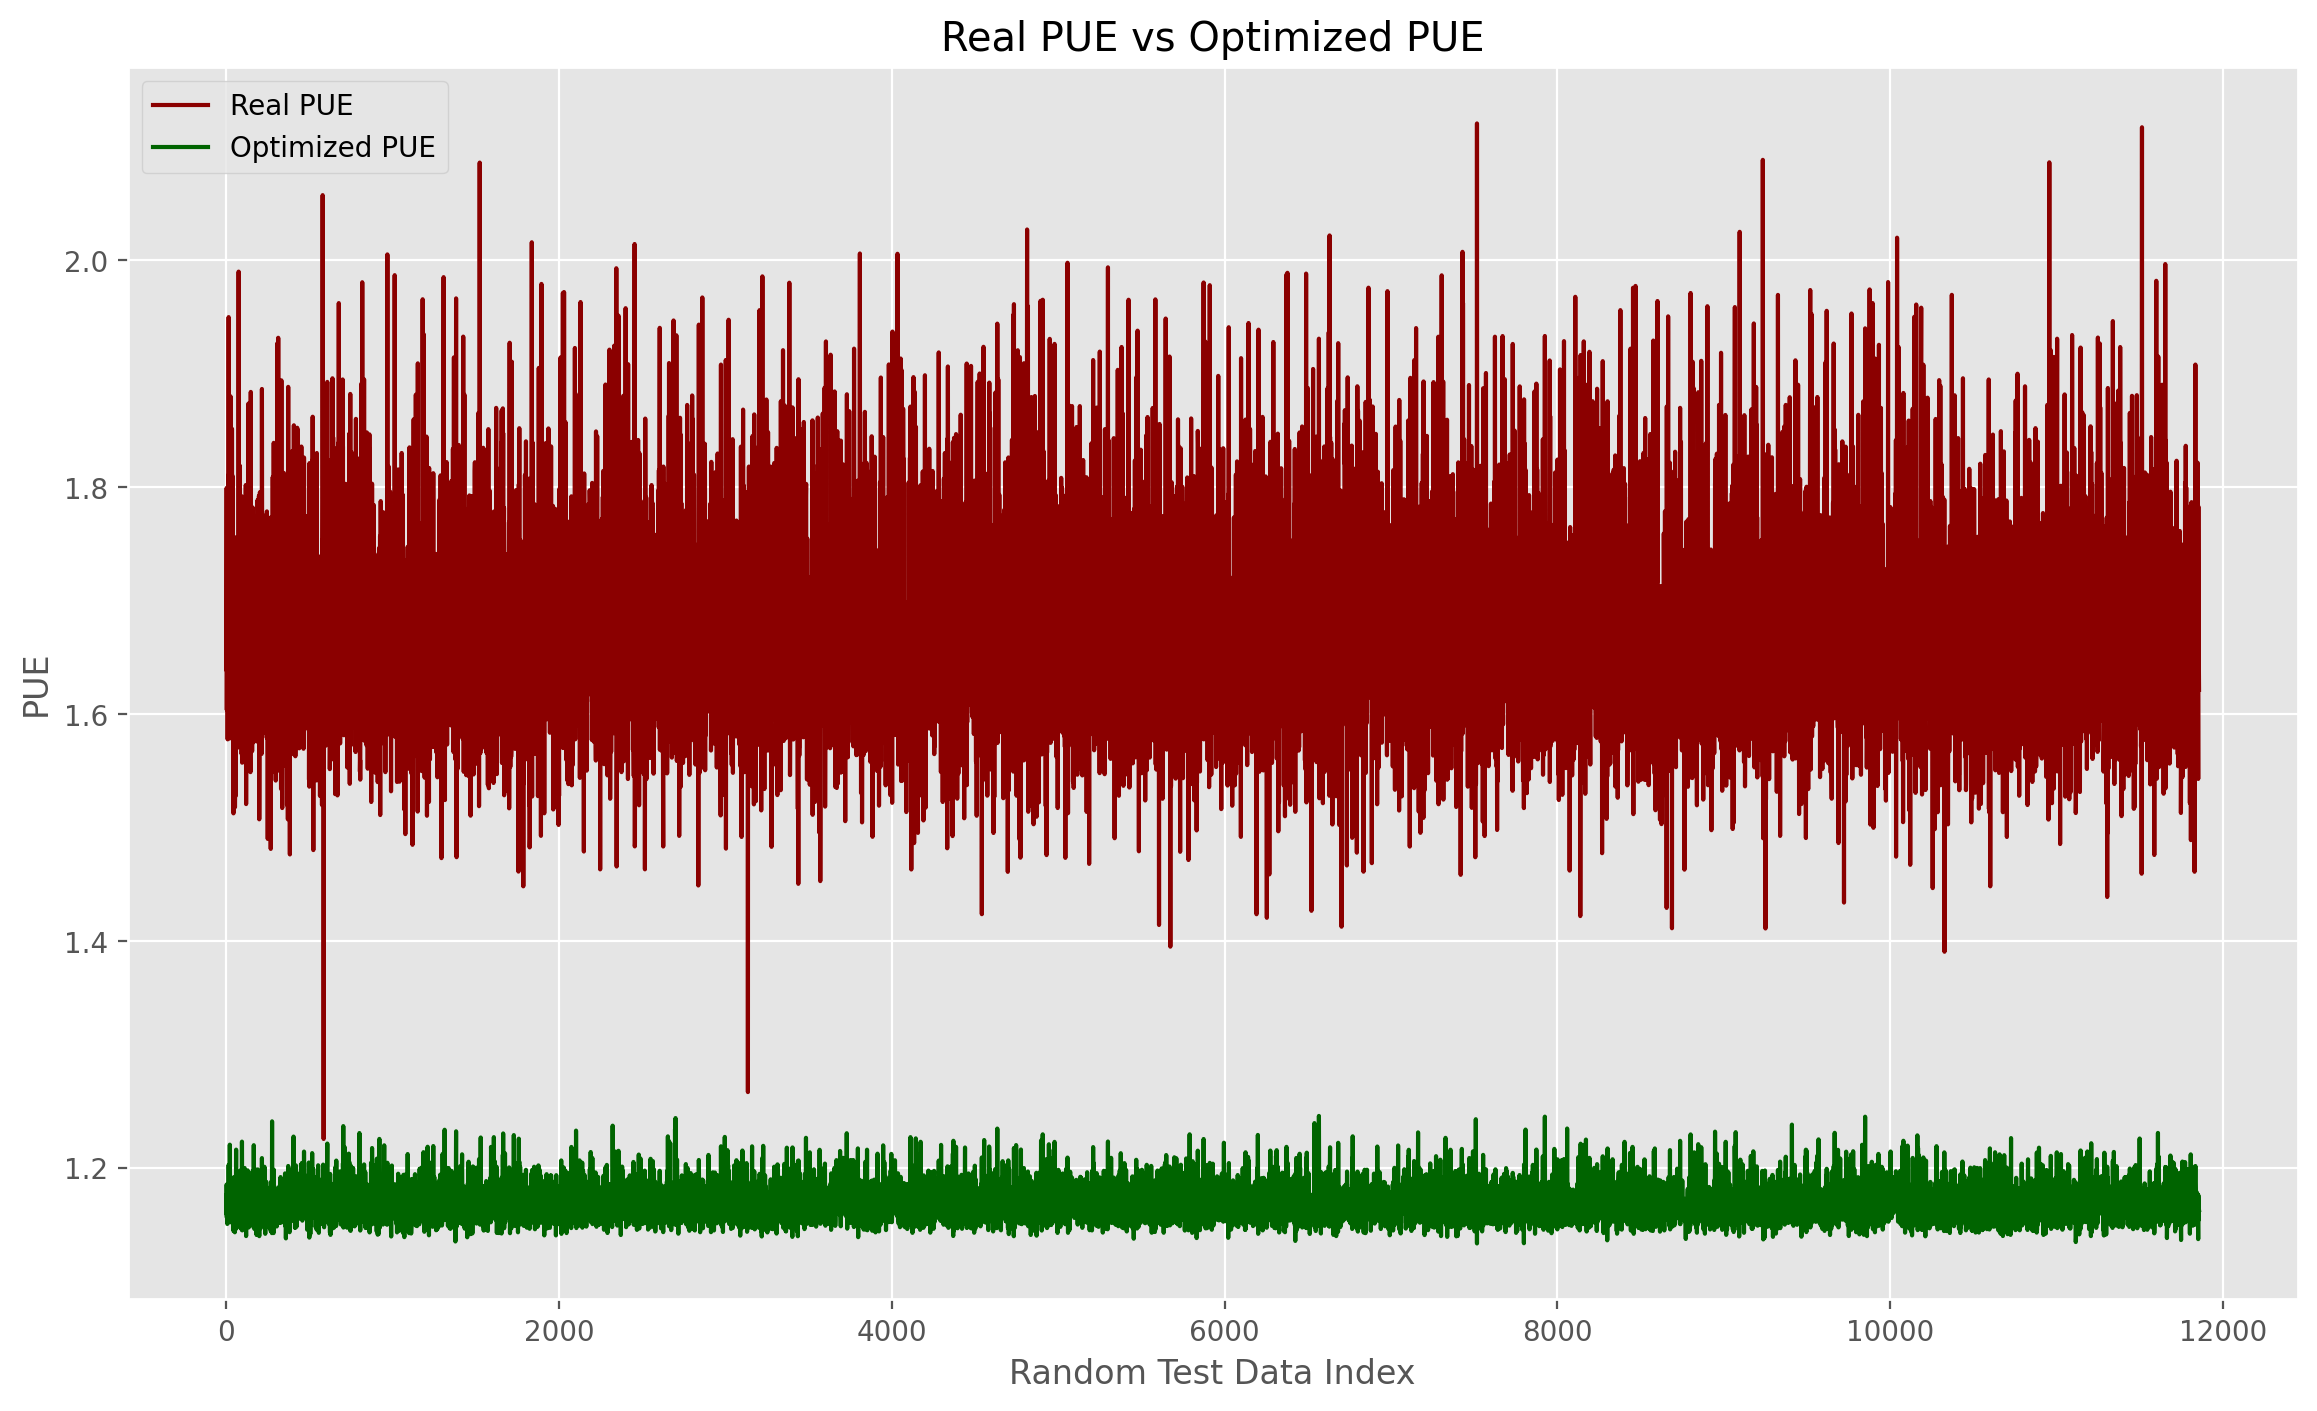

In [4]:
## set plot style
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14,8), dpi=200)
ax.plot(range(len(real_pue)), real_pue, color="darkred", label="Real PUE")
ax.plot(range(len(real_pue)), optimized_pue, color="darkgreen", label="Optimized PUE")
ax.legend()
ax.set_xlabel("Random Test Data Index")
ax.set_ylabel("PUE")
ax.set_title("Real PUE vs Optimized PUE")
plt.show()

## save
fig.savefig("real_vs_optimized_pue.png", dpi=200)

In [5]:
## detailed analysis
# calculate the difference between real and optimized PUE
diff = []
for i in range(len(real_pue)):
    diff.append(real_pue[i] - optimized_pue[i])

# calculate the percentage of the difference
diff_percentage = []
for i in range(len(real_pue)):
    diff_percentage.append((real_pue[i] - optimized_pue[i]) / real_pue[i])

# calculate the mean of the difference
mean_diff = np.mean(diff)
mean_diff_percentage = np.mean(diff_percentage)

## display the results
print(f"Mean difference: {mean_diff}")
print(f"Mean difference percentage: {mean_diff_percentage}")


Mean difference: 0.4983937806493757
Mean difference percentage: 0.29716862718560344


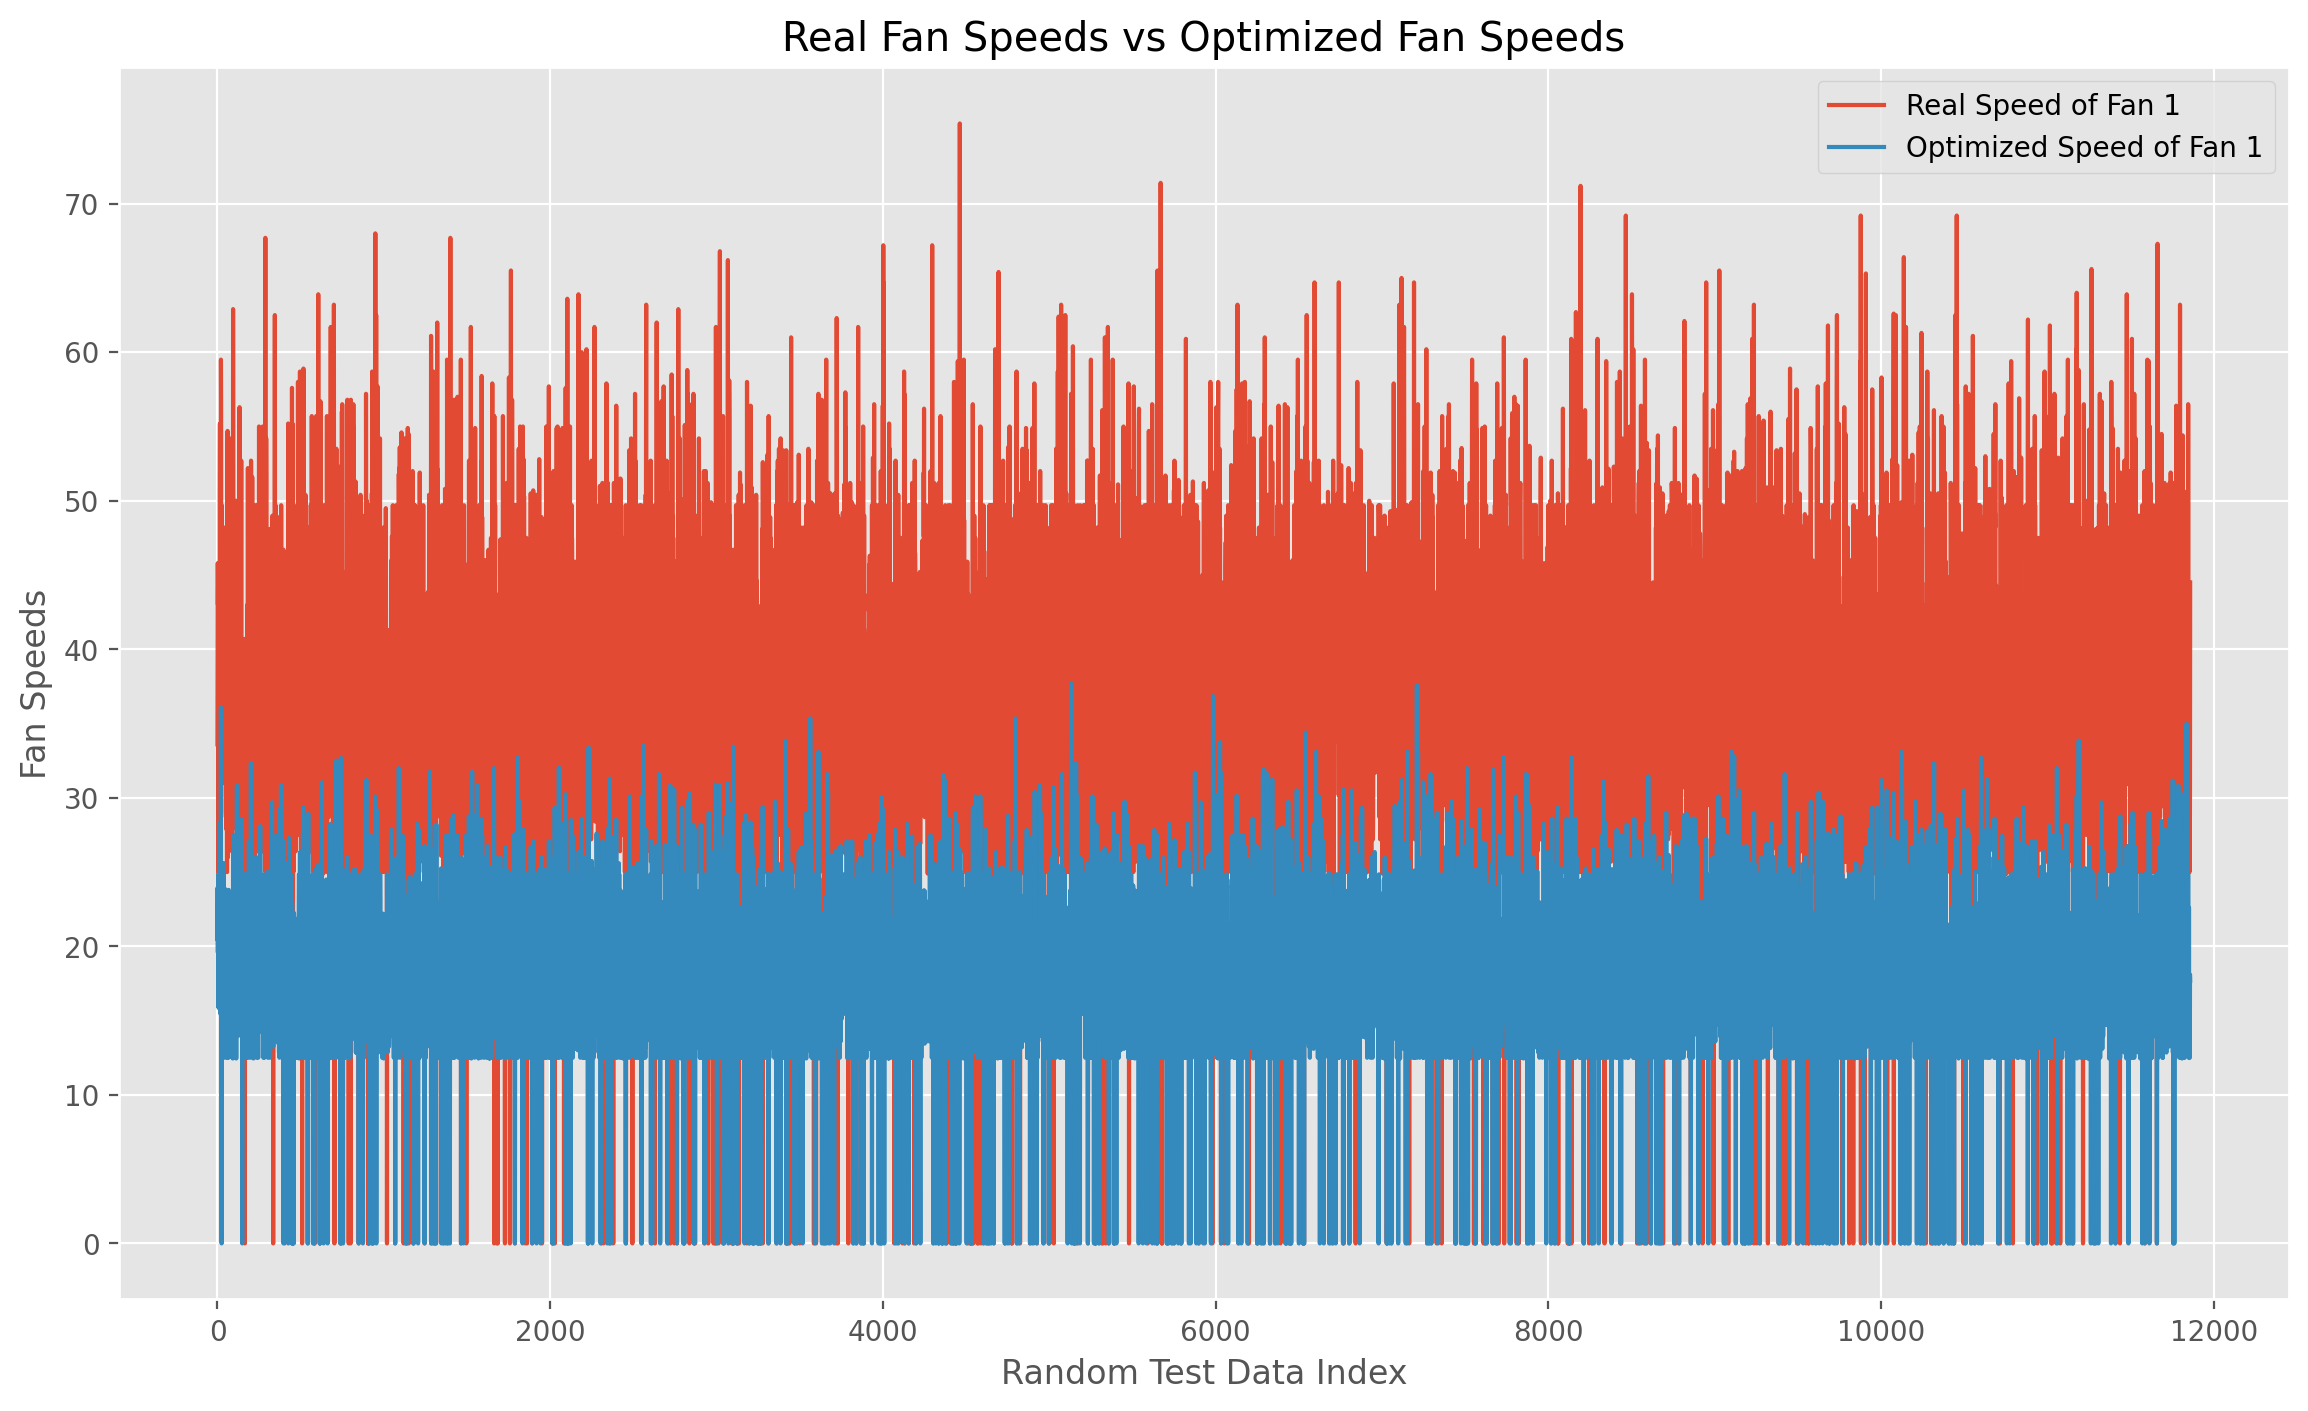

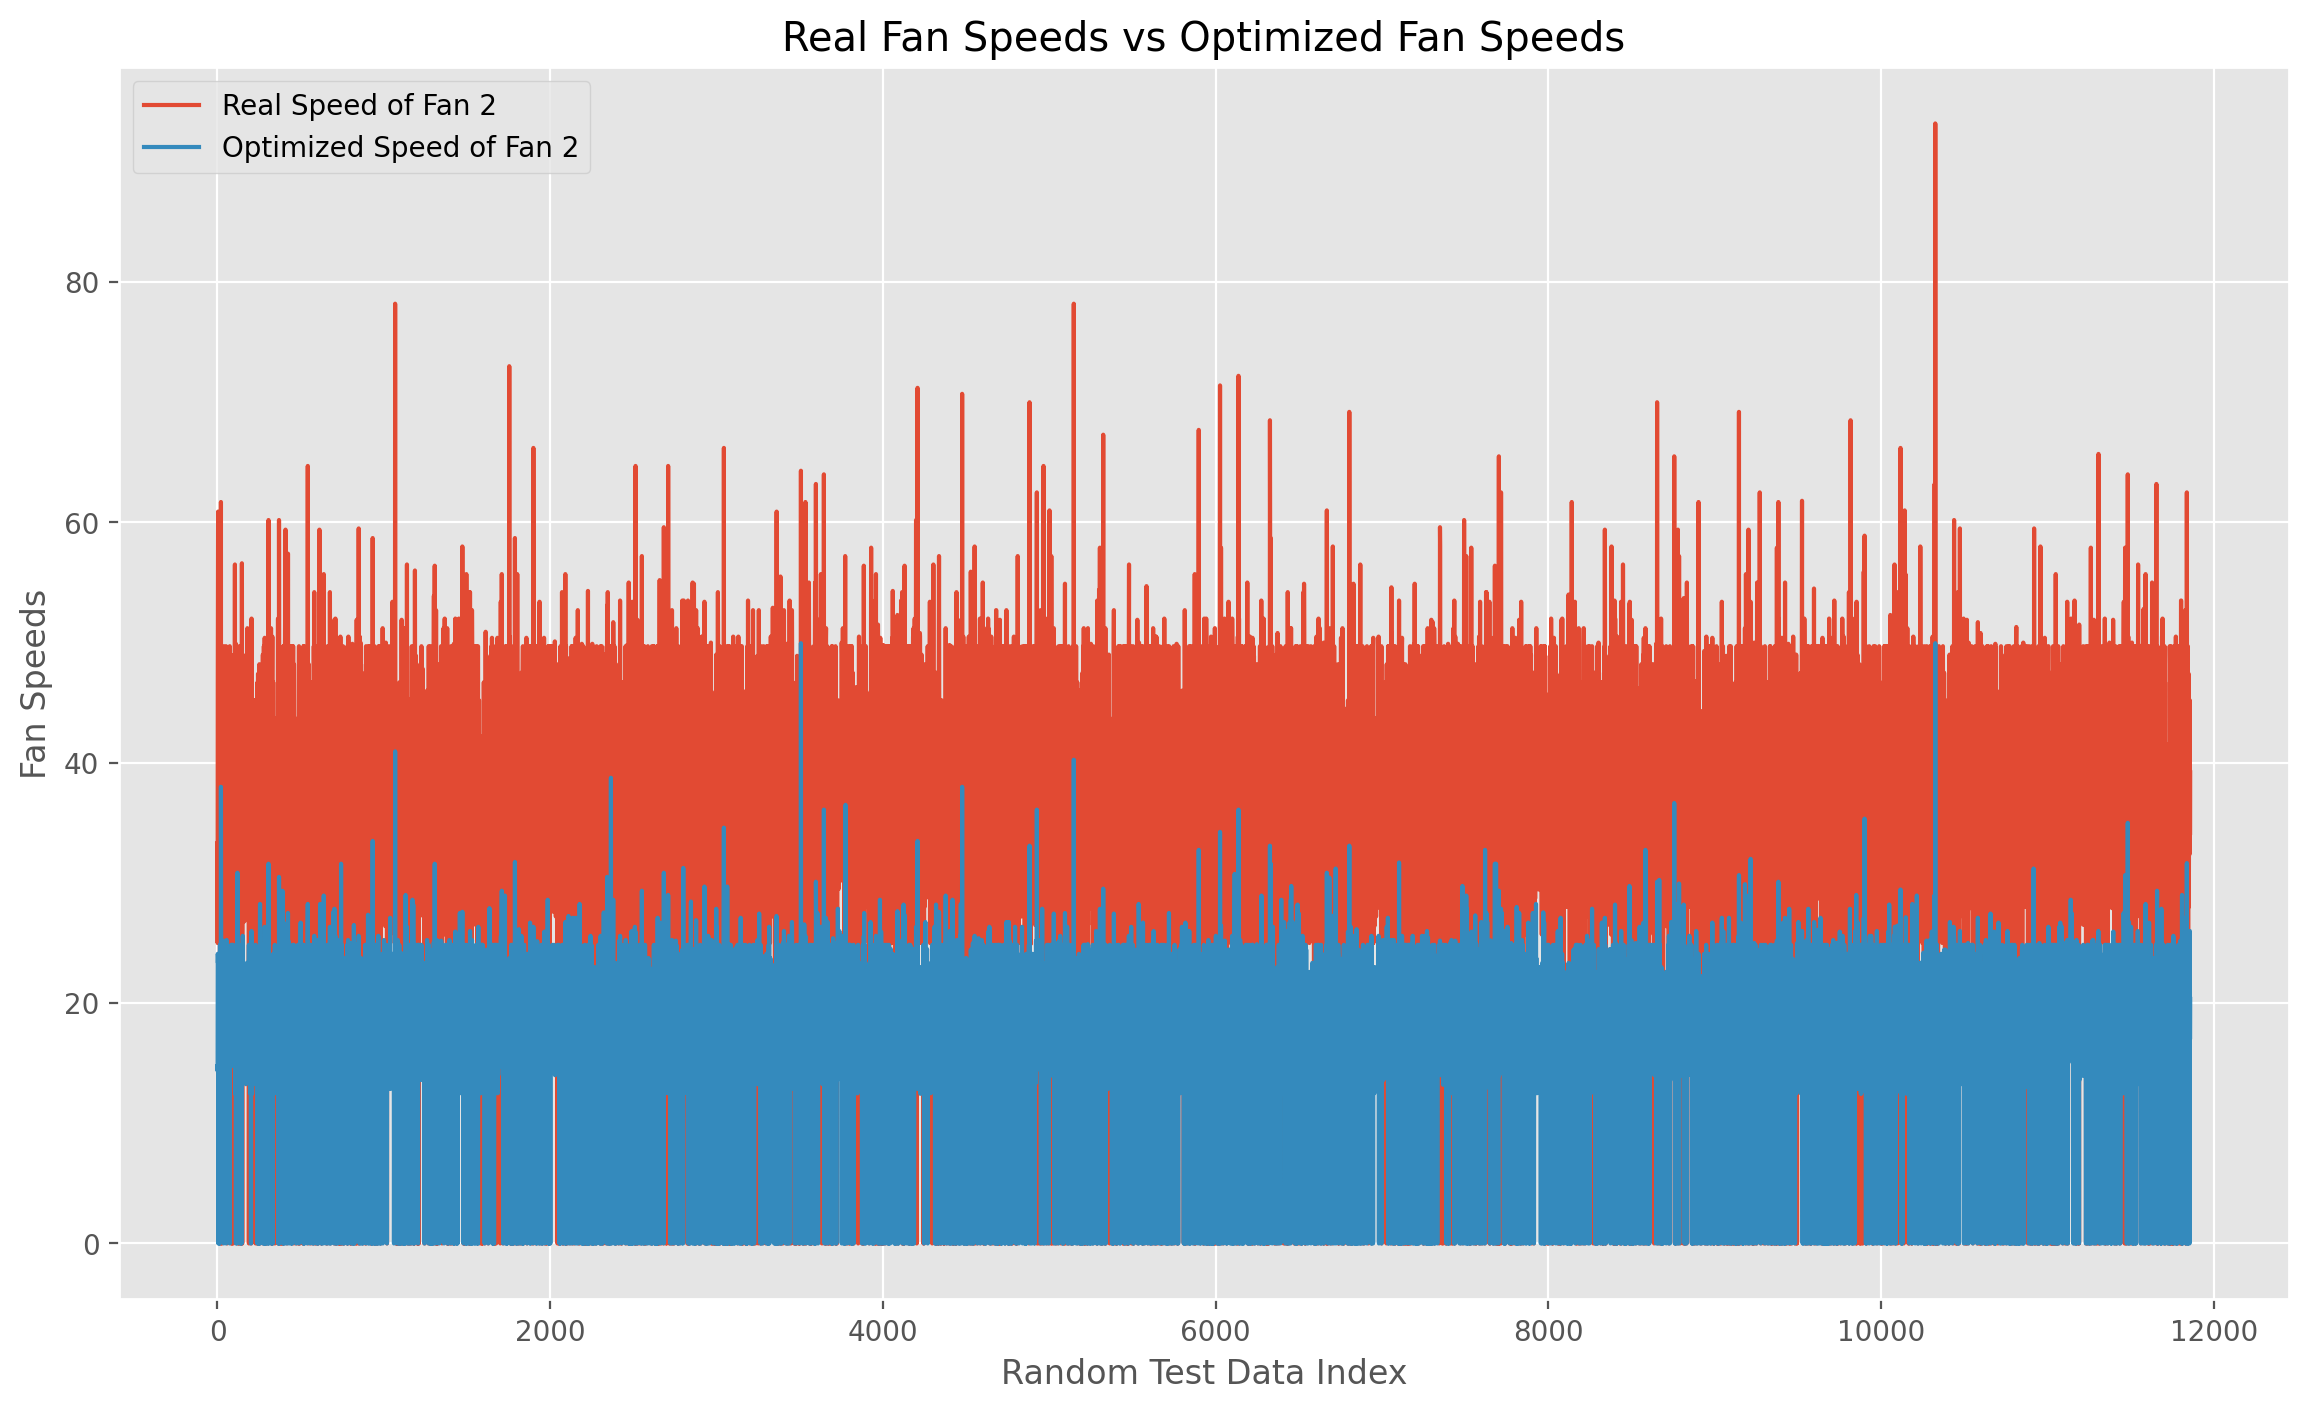

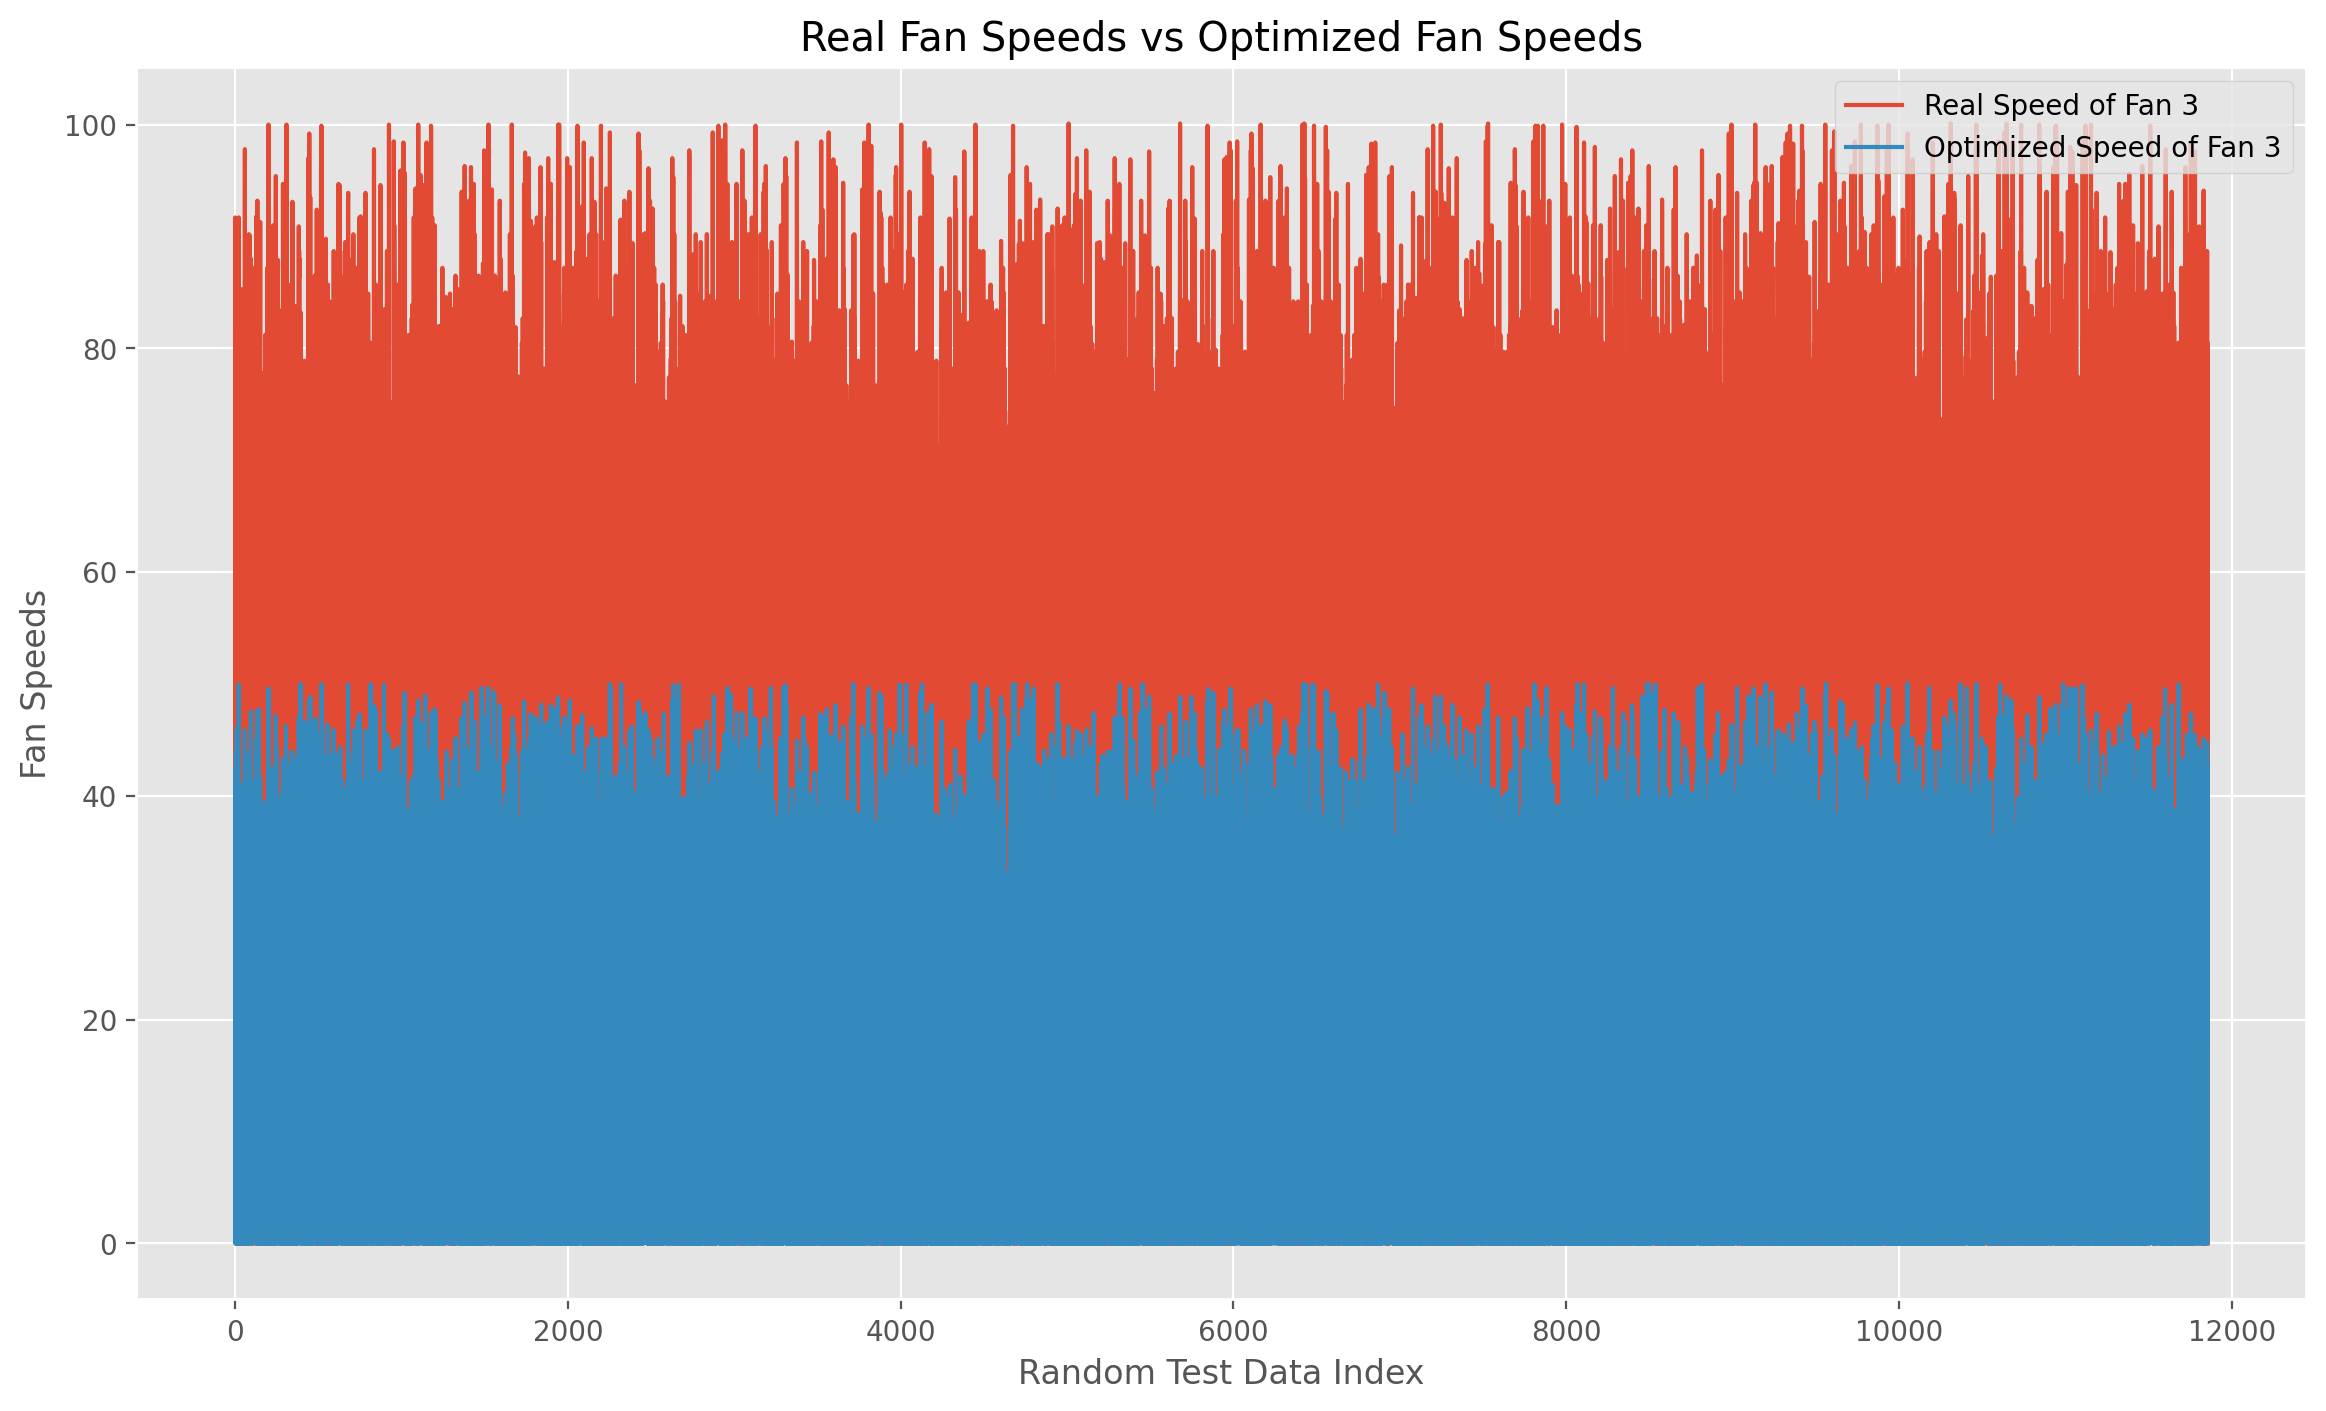

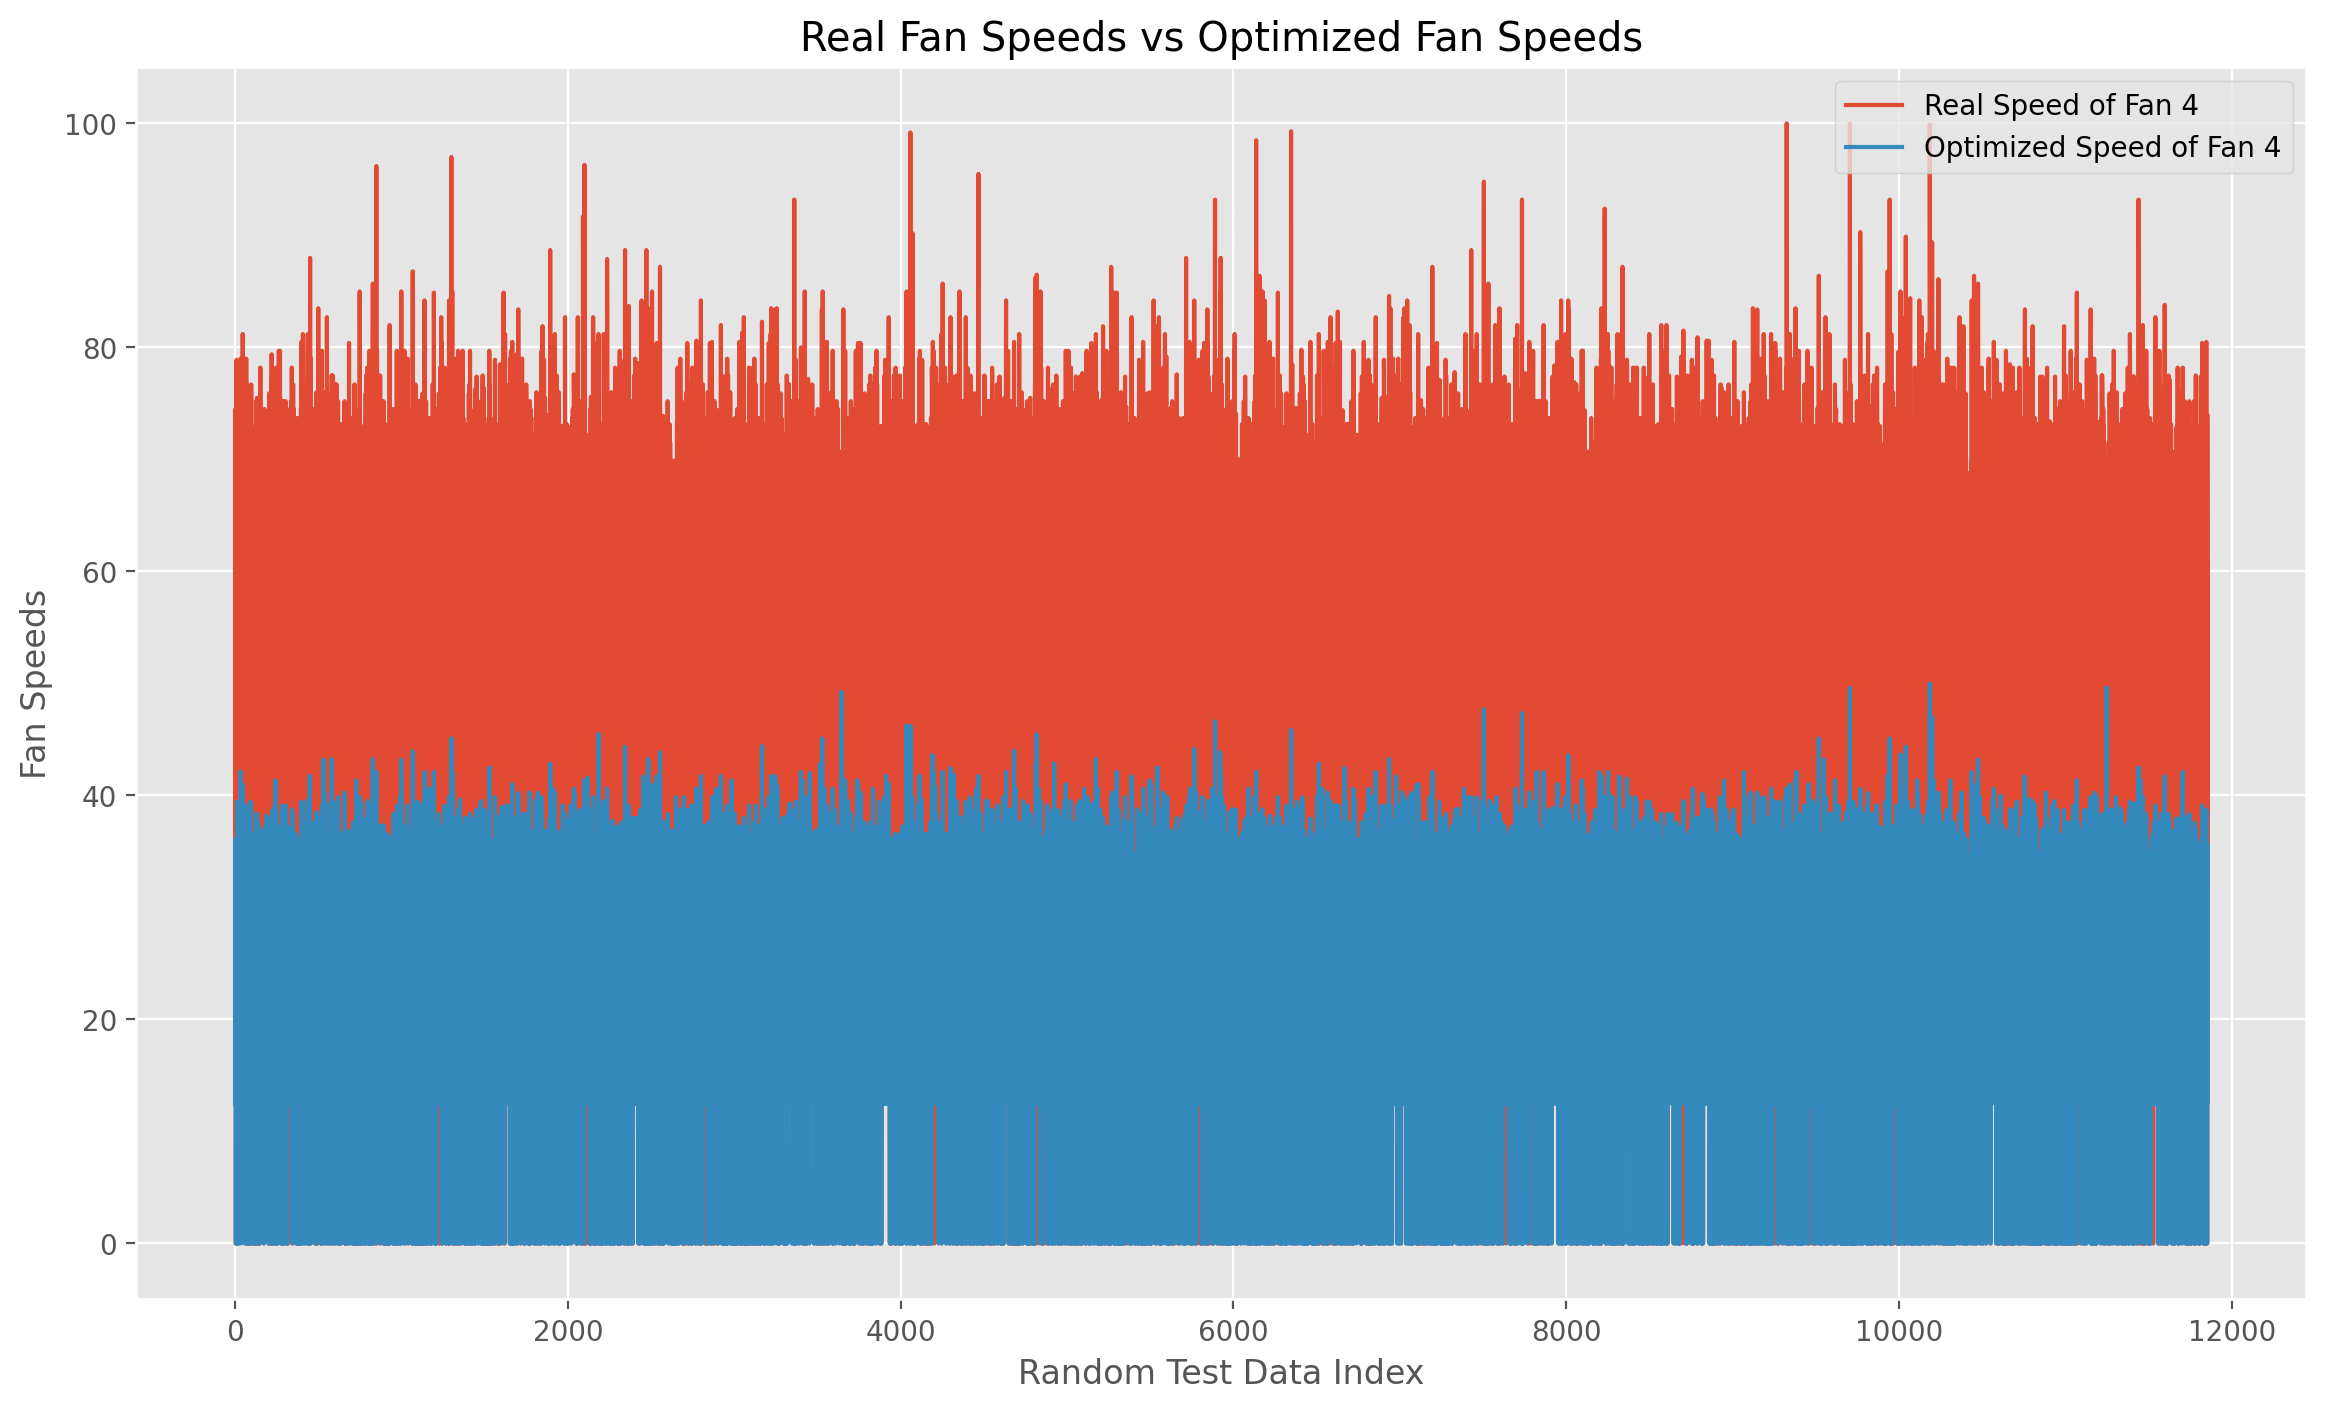

In [15]:
## plot speeds
for i in range(4):
    fig, ax = plt.subplots(figsize=(14,8), dpi=200)
    ax.plot(range(len(real_speeds)), real_speeds.iloc[:,i], label="Real Speed of Fan " + str(i+1))
    ax.plot(range(len(real_speeds)), optimized_speeds.iloc[:,i], label="Optimized Speed of Fan " + str(i+1))
    ax.legend()
    ax.set_xlabel("Random Test Data Index")
    ax.set_ylabel("Fan Speeds")
    ax.set_title("Real Fan Speeds vs Optimized Fan Speeds")
    plt.show()